# Notebook 5a - Using Total Sky Imager data to pick GOES cloud thresholds

From the Friday Harbor Labs Camera data, we found thresholds using visible reflectivity (green) and infrared (red). This performed well over the San Juan Islands but struggled significantly in mountainous areas with snow and glaciers. Using the decision tree, near IR (blue) was not used because it is unnecessary for precicting cloud cover over ocean/forests. To find the needed threshold combination that will work for those scenes and correctly identify clouds from snow, we will use Total Sky Imager data from Kettle Ponds, Colorado. 

Methods:
1. Process and load TSI data
    - need to ID what spatial domain TSI is looking at to select the correct GOES pixels
2. Load in GOES data for the East River and adjacent environs for Dec-Feb (high snow cover) and Jul-Sep (low/no snow cover)
3. Run the decision tree to find thresholds
    - add depth/branches to the tree to ensure it is using near IR as well as IR and visible

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


### Section 0 - Define time range

In [2]:
start_time = "2022-04-01"
end_time = "2023-06-01"

# Convert start_time and end_time to numpy.datetime64
start_time = np.datetime64(start_time)
end_time = np.datetime64(end_time)

### Section 1 - Process TSI data

In [3]:
tsi_ds = xr.open_dataset('/storage/cdalden/goes/surface_obs/sail_total_sky_imager/tsi_skycover_20210901_20230616.nc')

# Select time range and filter between 8am local and 6pm local (MDT) in one step
tsi_ds = tsi_ds.sel(
    time=tsi_ds['time'].where(
        (tsi_ds['time'] >= start_time) & 
        (tsi_ds['time'] <= end_time) & 
        (tsi_ds['time'].dt.hour >= 14)
    ).dropna('time')
)

da_percent_opaque =  tsi_ds['percent_opaque']

# Create a new cloud binary variable
tsi_ds['cloud_binary'] = xr.where(
    tsi_ds['percent_opaque'] > 75, 1,  # Cloudy: Set to 1 when > 75
    xr.where(tsi_ds['percent_opaque'] < 25, 0,  # Clear: Set to 0 when >= 0 and < 25
        np.nan  # Otherwise, set to NaN (nighttime and mixed cloud cover)
    ))

### Section 2 - Compare to GOES pixels

In [5]:
def combine_daily_rgb_to_monthly(month, year):
    # List to store datasets
    datasets = []

    if month in ['01', '03', '05', '07', '08', '10', '12']:
        end_day_of_month = 32
    elif month in ['04', '06', '09', '11']:
        end_day_of_month = 31
    elif month == '02':  # February, be careful about leap years
        end_day_of_month = 29

    # Loop through all the files
    for i in range(1, end_day_of_month):  # Loop from 1 to 29
        # Make i two digits
        day = f"{i:02}"
        input_path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
        input_file = 'goes16_C02_C05_C13_rgb_colorado_{year}{month}{day}.nc'.format(year=year, month=month, day=day)
        
        # Open the dataset
        try:
            dataset = xr.open_dataset(input_path + input_file)
            
            # Select pixels where latitude is between 39.065 and 38.904, and longitude is between -107.08 and -106.993
            dataset = dataset.sel(
                latitude=slice(39.065, 38.904),
                longitude=slice(-107.08, -106.993)
            )
            
            # Append the spatially subsetted dataset to the list
            datasets.append(dataset)
        
        except Exception as e:
        # Print the error and continue with the next file
            print(f"Error: {e} for file {year}{month}{day}")

    # Combine all datasets along the 'time' dimension
    combined_dataset = xr.concat(datasets, dim='t', combine_attrs='override')
    print('done with combo')


    # Save the combined dataset to a new NetCDF file
    output_filepath = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
    output_filename = 'combined_goes16_C02_C05_C13_rgb_colorado_{year}{month}.nc'.format(year=year, month=month)
    combined_dataset.to_netcdf(output_filepath + output_filename)
    print('processed and saved RGB file to {i}'.format(i=output_filename))

    return combined_dataset


In [6]:
# ds = combine_daily_rgb_to_monthly('04', '2023')

done with combo
processed and saved RGB file to combined_goes16_C02_C05_C13_rgb_colorado_202304.nc


In [8]:
path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
file_template = 'combined_goes16_C02_C05_C13_rgb_colorado_{yearmonth}.nc'
datasets = {}
files = ['202205', '202206', '202304', '202305']

for file in files:
    datasets[file] = xr.open_dataset(path + file_template.format(yearmonth=file))
    print('opened {i}'.format(i=file))

if len(files) > 1:
    ds = xr.concat([datasets[file] for file in files], dim='t', combine_attrs='override')
else:
    ds = (datasets[files[0]])
ds = ds.rename({'t': 'time'})
ds

opened 202205
opened 202206
opened 202305


<xarray.Dataset> Size: 225MB
Dimensions:    (time: 26496, latitude: 25, longitude: 17)
Coordinates:
  * time       (time) datetime64[ns] 212kB 2022-05-01T00:02:30 ... 2023-05-31...
  * latitude   (latitude) float64 200B 39.06 39.05 39.05 ... 38.92 38.92 38.91
  * longitude  (longitude) float64 136B -107.1 -107.1 -107.1 ... -107.0 -107.0
Data variables:
    green      (time, latitude, longitude) float32 45MB 0.2035 0.3998 ... 0.2741
    blue       (time, latitude, longitude) float64 90MB 0.03935 ... 0.1258
    red        (time, latitude, longitude) float64 90MB 0.1405 0.1405 ... 0.592

In [9]:
# Compute spatial averages for red, green, and blue bands over x and y dimensions
spatial_avg = ds[['red', 'green', 'blue']].mean(dim=['latitude', 'longitude'])

# Select time range and filter between hour 14 and 21 UTC in one step
spatial_avg = spatial_avg.sel(
    time=spatial_avg['time'].where(
        (spatial_avg['time'] >= start_time) & 
        (spatial_avg['time'] <= end_time) & 
        (spatial_avg['time'].dt.hour >= 14)
    ).dropna('time')
)
# spatial_avg = spatial_avg.compute()
print('done spatial avg')

done spatial avg


### Section 3 - Align GOES and TSI data

In [10]:
# Select the nearest TSI timesteps for each spatial_avg timestep
nearest_tsi = tsi_ds['cloud_binary'].sel(time=spatial_avg['time'], method='nearest')
# Ensure no duplicate timestamps in the nearest_tsi dataset
nearest_tsi = nearest_tsi.drop_duplicates(dim='time')

In [18]:
spatial_avg['cloud_binary'] = nearest_tsi

# for testing, let's slice the training ds a little
goes_tsi_ds = spatial_avg.sel(time=slice('2023-05-01', '2023-05-31'))
goes_tsi_ds

<xarray.Dataset> Size: 134kB
Dimensions:       (time: 3720)
Coordinates:
  * time          (time) datetime64[ns] 30kB 2023-05-01T14:02:30 ... 2023-05-...
Data variables:
    red           (time) float64 30kB 0.1405 0.1369 0.1338 ... 0.653 0.65 0.6416
    green         (time) float32 15kB 0.2345 0.2471 0.2589 ... 0.4224 0.391
    blue          (time) float64 30kB 0.01713 0.01969 0.02144 ... 0.2883 0.2717
    cloud_binary  (time) float64 30kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 nan

In [19]:
# Create a mask where all variables are non-NaN
mask = ~goes_tsi_ds.to_array().isnull().any(dim='variable')

# Apply the mask to filter the dataset
goes_tsi_ds = goes_tsi_ds.sel(time=goes_tsi_ds['time'][mask])

print(str(np.round(goes_tsi_ds.nbytes/10000,1)) + 'mb')

8.9mb


### Section 4 - Create Decision Tree to find thresholds 

Performance Metrics:
Accuracy: 0.98
Precision: 0.97
Recall: 0.99
F1 Score: 0.98

Classification Report:
              precision    recall  f1-score   support

    No Cloud       0.99      0.97      0.98       365
       Cloud       0.97      0.99      0.98       375

    accuracy                           0.98       740
   macro avg       0.98      0.98      0.98       740
weighted avg       0.98      0.98      0.98       740



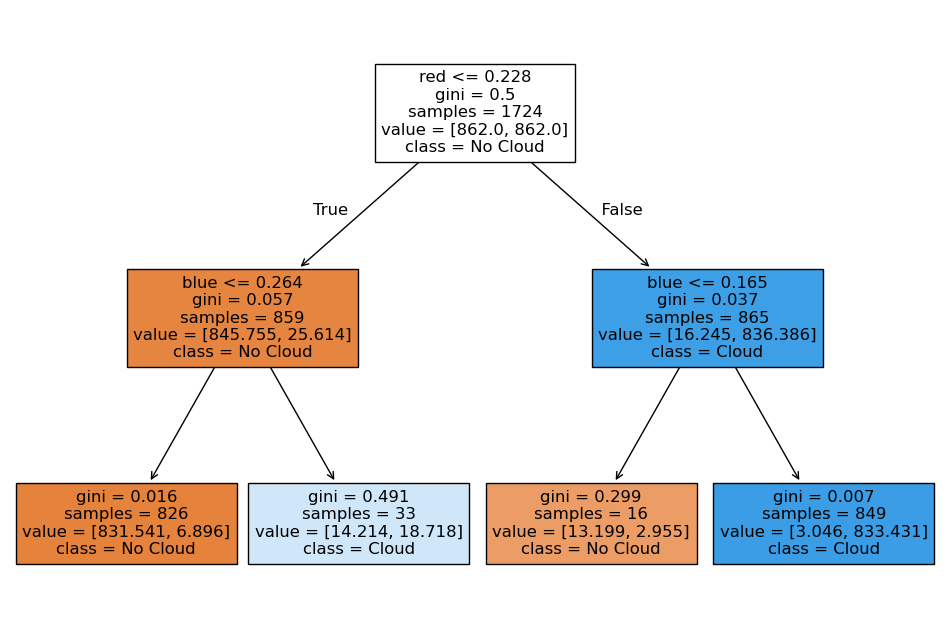

|--- red <= 0.23
|   |--- blue <= 0.26
|   |   |--- class: 0.0
|   |--- blue >  0.26
|   |   |--- class: 1.0
|--- red >  0.23
|   |--- blue <= 0.16
|   |   |--- class: 0.0
|   |--- blue >  0.16
|   |   |--- class: 1.0



In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prepare the data
X = goes_tsi_ds[['red', 'green', 'blue']].to_dataframe().dropna()
y = goes_tsi_ds['cloud_binary'].to_dataframe().loc[X.index]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=10, class_weight='balanced', random_state=42)  # Limit depth for interpretability
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Cloud', 'Cloud']))

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['red', 'green', 'blue'], class_names=['No Cloud', 'Cloud'], filled=True)
plt.show()

# Output the decision rules
tree_rules = export_text(clf, feature_names=['red', 'green', 'blue'])
print(tree_rules)

In [21]:
# Print feature importance
feature_importances = clf.feature_importances_
for feature, importance in zip(['red', 'green', 'blue'], feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print the training and evaluation sample sizes
print(f"Training sample size: {len(X_train)}")
print(f"Evaluation sample size: {len(X_test)}")

Feature: red, Importance: 0.9503
Feature: green, Importance: 0.0000
Feature: blue, Importance: 0.0497
Training sample size: 1724
Evaluation sample size: 740


### Independent evaluation of thresholds against TSI data

In [24]:
eval_ds = spatial_avg.sel(time=slice('2022-05-01', '2022-05-31'))
# Create a mask where all variables are non-NaN
mask = ~eval_ds.to_array().isnull().any(dim='variable')

# Apply the mask to filter the dataset
eval_ds = eval_ds.sel(time=eval_ds['time'][mask])

In [25]:
# Step 1: Extract features (red, green, blue) and labels (cloud_binary)
features = np.column_stack([
    eval_ds['red'].values,
    eval_ds['green'].values,
    eval_ds['blue'].values
])
labels = eval_ds['cloud_binary'].values

# Step 2: Predict using the trained decision tree
# Assuming `decision_tree` is your trained model
predictions = clf.predict(features)

# Step 3: Evaluate the model
# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(labels, predictions, target_names=['No Cloud', 'Cloud'])
print(report)

Accuracy: 0.97
              precision    recall  f1-score   support

    No Cloud       0.98      0.96      0.97      1660
       Cloud       0.94      0.98      0.96      1104

    accuracy                           0.97      2764
   macro avg       0.96      0.97      0.97      2764
weighted avg       0.97      0.97      0.97      2764



/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
